In [41]:
# Step 1: Data Cleaning and Preprocessing

import pandas as pd

# Load the data (adjust the file path as needed)
file_path = 'orders_discount_data.xlsx'
data = pd.read_excel(file_path)

# 1. Remove unnecessary columns
data_cleaned = data.drop(columns=['Unnamed: 0'], errors='ignore')

# 2. Convert date_of_order to datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# 3. Check for missing values
missing_values = data_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)

# 4. Convert department_desc to categorical
data_cleaned['department_desc'] = data_cleaned['department_desc'].astype('category')

# Display the cleaned data
print("\nCleaned Data (First 5 rows):")
print(data_cleaned.head())


Missing values per column:
 product_number     0
department_desc    0
discount           0
date_of_order      1
orders             1
dtype: int64

Cleaned Data (First 5 rows):
  product_number department_desc  discount date_of_order  orders
0              0               0      0.00    2018-06-15     6.0
1              0               0     36.59    2018-01-07    12.0
2              0               0     36.59    2018-02-07    15.0
3              0               0     36.59    2018-03-07     6.0
4              0               0     36.59    2018-04-07    30.0


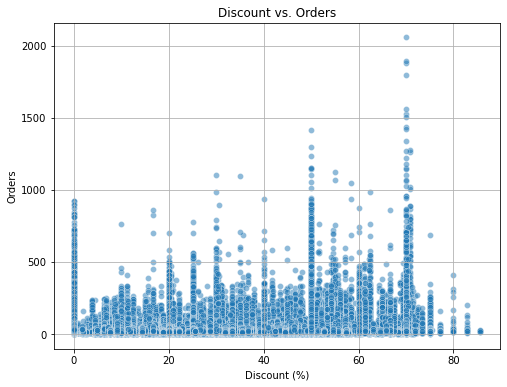

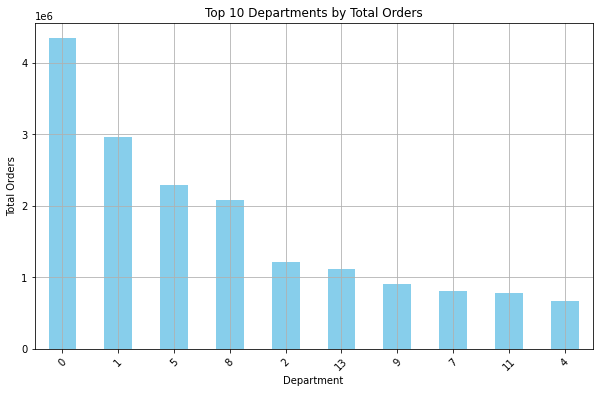

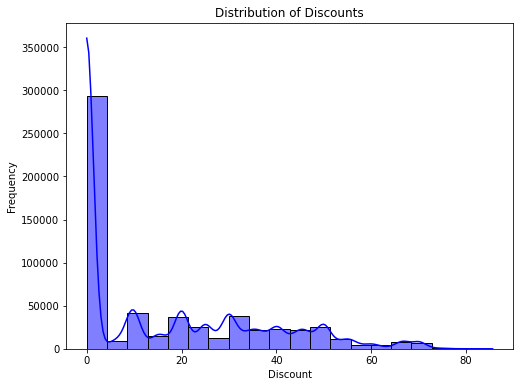

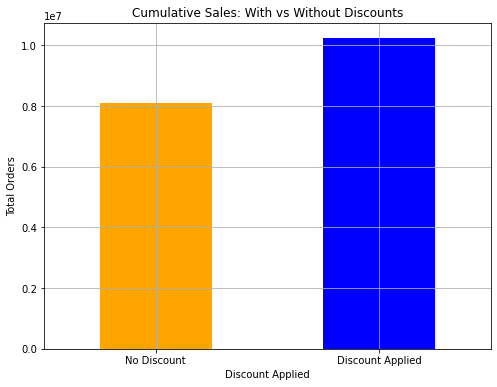

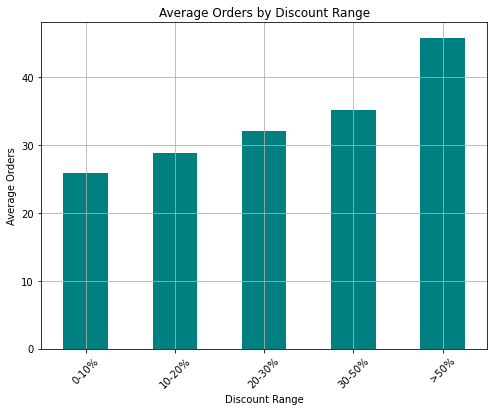

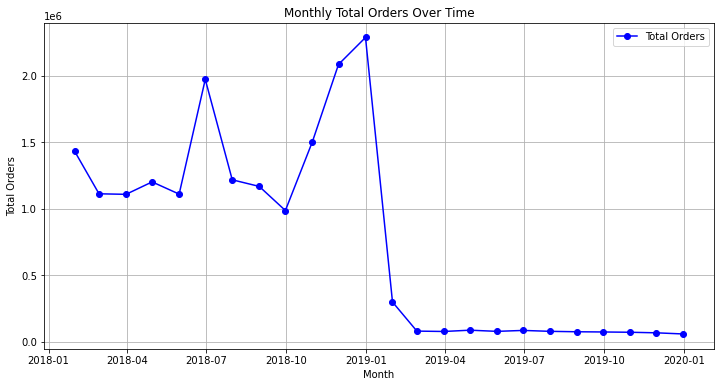

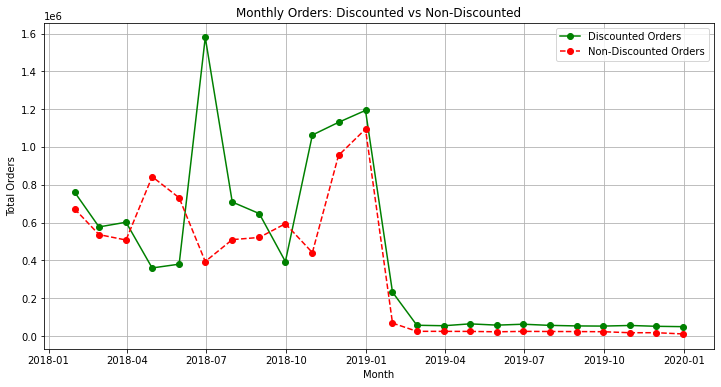

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `data_cleaned` is already available from Step 1

# 1. Scatter Plot: Discount vs Orders
plt.figure(figsize=(8, 6))
sns.scatterplot(x='discount', y='orders', data=data_cleaned, alpha=0.5)
plt.title('Discount vs. Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Orders')
plt.grid(True)
plt.show()


# 2. Department-wise Discount Sensitivity
dept_analysis = data_cleaned.groupby('department_desc')['orders'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
dept_analysis.head(10).plot(kind='bar', color='skyblue')  # Show only top 10 departments
plt.title('Top 10 Departments by Total Orders')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Distribution of Discounts
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue')
plt.title('Distribution of Discounts')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

# 4. Cumulative Sales: With vs Without Discounts
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
cumulative_sales = data_cleaned.groupby('discount_applied')['orders'].sum()

cumulative_sales.plot(kind='bar', color=['orange', 'blue'], figsize=(8, 6))
plt.title('Cumulative Sales: With vs Without Discounts')
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.grid(True)
plt.show()

# 5. Effectiveness of Discounts: Average Orders by Discount Range
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=[0, 10, 20, 30, 50, 100],
                                        labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

avg_orders_by_discount.plot(kind='bar', color='teal', figsize=(8, 6))
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# 6. Resample Data to Monthly Sales
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'])  # Ensure date format
monthly_sales = data_cleaned.resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', linestyle='-', color='blue', label='Total Orders')
plt.title('Monthly Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()

 # 7.Discounted vs Non-Discounted Orders Over Time
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
monthly_sales_discounted = data_cleaned[data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()
monthly_sales_non_discounted = data_cleaned[~data_cleaned['discount_applied']].resample('M', on='date_of_order')['orders'].sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_discounted, marker='o', linestyle='-', color='green', label='Discounted Orders')
plt.plot(monthly_sales_non_discounted, marker='o', linestyle='--', color='red', label='Non-Discounted Orders')
plt.title('Monthly Orders: Discounted vs Non-Discounted')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.legend()
plt.show()



Average Price Elasticity of Demand: 1.9185830440345129
Demand is elastic: Customers are highly responsive to discounts.
Elasticity by Department:
department_desc
0                       2.583152
1                       1.296842
2                       2.615982
3                       0.748450
4                       2.322584
5                       1.207638
6                       0.544885
7                       2.119567
8                       2.278214
2018-11-11 00:00:00     0.000000
9                       2.633435
10                      0.588883
11                      0.718490
12                      1.400837
13                      1.101795
14                     36.490352
15                      0.189068
Name: elasticity, dtype: float64


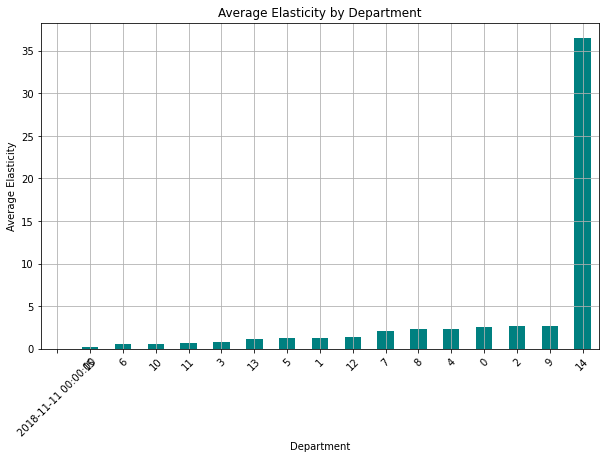

Pearson Correlation Coefficient: 0.23175055312555068
Spearman Correlation Coefficient: 0.21234024295950465
Kendall Correlation Coefficient: 0.1506059959041548


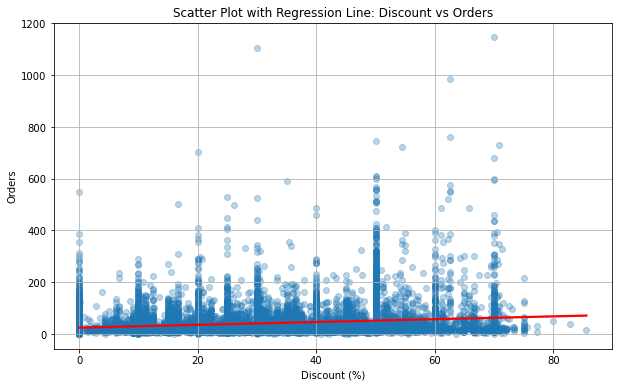

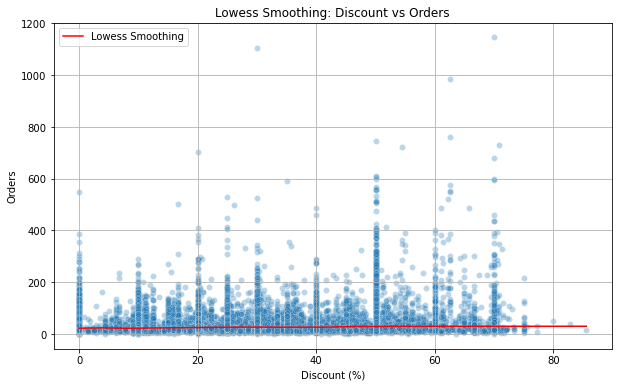

Number of valid discounted rows: 18529
Number of valid non-discounted rows: 6738
T-statistic: 26.441978873317257, P-value: 8.071057277111177e-152
Reject the null hypothesis: Discounts have a significant effect on sales.
Bootstrapped Confidence Interval for Mean Difference: [11.44641048 13.37904327]
Cohen's d (Effect Size): 0.3181597039905436


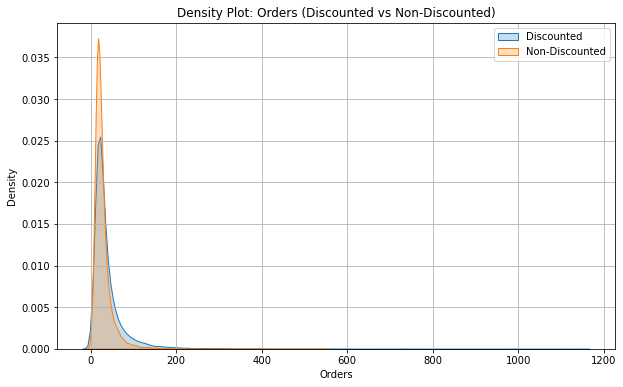

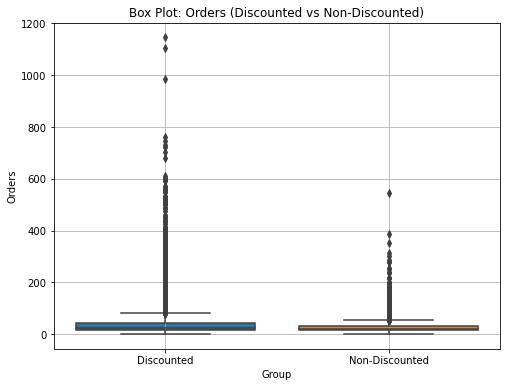

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Assuming `data_cleaned` is already loaded and cleaned from previous steps

# 1. Elasticity Analysis
# Percentage change for orders and discount
data_cleaned['pct_change_orders'] = data_cleaned['orders'].pct_change()
data_cleaned['pct_change_discount'] = data_cleaned['discount'].pct_change()

# Avoid division by zero
data_cleaned = data_cleaned.dropna(subset=['pct_change_orders', 'pct_change_discount'])
data_cleaned = data_cleaned[data_cleaned['pct_change_discount'] != 0]

data_cleaned['elasticity'] = data_cleaned['pct_change_orders'] / data_cleaned['pct_change_discount']

# Drop NaN or infinity values
data_cleaned['elasticity'] = data_cleaned['elasticity'].replace([np.inf, -np.inf], np.nan)
data_cleaned = data_cleaned.dropna(subset=['elasticity'])

# Average Elasticity
average_elasticity = data_cleaned['elasticity'].mean()
print(f"Average Price Elasticity of Demand: {average_elasticity}")

# Interpretation
if average_elasticity > 1:
    print("Demand is elastic: Customers are highly responsive to discounts.")
elif average_elasticity < 1:
    print("Demand is inelastic: Customers are less responsive to discounts.")
else:
    print("Demand has unit elasticity.")

# Group-Level Elasticity Analysis
group_elasticity = data_cleaned.groupby('department_desc')['elasticity'].mean()
print("Elasticity by Department:")
print(group_elasticity)

# Visualize Group-Level Elasticity
group_elasticity.sort_values().plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('Average Elasticity by Department')
plt.xlabel('Department')
plt.ylabel('Average Elasticity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. Statistical Correlation
# Pearson, Spearman, and Kendall Correlations
pearson_corr = data_cleaned['discount'].corr(data_cleaned['orders'], method='pearson')
spearman_corr = data_cleaned['discount'].corr(data_cleaned['orders'], method='spearman')
kendall_corr = data_cleaned['discount'].corr(data_cleaned['orders'], method='kendall')

print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"Kendall Correlation Coefficient: {kendall_corr}")

# Visualize with Scatter Plot and Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='discount', y='orders', data=data_cleaned, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Scatter Plot with Regression Line: Discount vs Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

# Lowess Smoothing
lowess = sm.nonparametric.lowess
lowess_values = lowess(data_cleaned['orders'], data_cleaned['discount'], frac=0.3)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='orders', data=data_cleaned, alpha=0.3)
plt.plot(lowess_values[:, 0], lowess_values[:, 1], color='red', label='Lowess Smoothing')
plt.title('Lowess Smoothing: Discount vs Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.show()

# 3. Hypothesis Testing
# Split data into discounted and non-discounted groups
discounted = data_cleaned[data_cleaned['discount'] > 0]['orders']
non_discounted = data_cleaned[data_cleaned['discount'] == 0]['orders']

# Remove invalid rows
discounted = discounted[discounted > 0].dropna()
non_discounted = non_discounted[non_discounted > 0].dropna()

# Check data validity
print(f"Number of valid discounted rows: {len(discounted)}")
print(f"Number of valid non-discounted rows: {len(non_discounted)}")

# Ensure sufficient data points and variance
if len(discounted) < 2 or len(non_discounted) < 2:
    print("Insufficient data points for t-test in one or both groups.")
elif np.var(discounted) == 0 or np.var(non_discounted) == 0:
    print("One of the groups has no variance, making t-test invalid.")
else:
    # Perform t-test
    t_stat, p_value = ttest_ind(discounted, non_discounted, equal_var=False)
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

    # Interpret the results
    if p_value < 0.05:
        print("Reject the null hypothesis: Discounts have a significant effect on sales.")
    else:
        print("Fail to reject the null hypothesis: Discounts do not have a significant effect on sales.")

# Bootstrapping for Confidence Intervals
n_iterations = 1000
mean_diff_samples = []
for _ in range(n_iterations):
    sampled_discounted = discounted.sample(len(discounted), replace=True)
    sampled_non_discounted = non_discounted.sample(len(non_discounted), replace=True)
    mean_diff_samples.append(sampled_discounted.mean() - sampled_non_discounted.mean())

conf_interval = np.percentile(mean_diff_samples, [2.5, 97.5])
print(f"Bootstrapped Confidence Interval for Mean Difference: {conf_interval}")

# Effect Size (Cohen's d)
mean_diff = discounted.mean() - non_discounted.mean()
pooled_std = np.sqrt((np.var(discounted) + np.var(non_discounted)) / 2)
cohens_d = mean_diff / pooled_std
print(f"Cohen's d (Effect Size): {cohens_d}")

# Visualize Group Differences
plt.figure(figsize=(10, 6))
sns.kdeplot(discounted, label='Discounted', shade=True)
sns.kdeplot(non_discounted, label='Non-Discounted', shade=True)
plt.title('Density Plot: Orders (Discounted vs Non-Discounted)')
plt.xlabel('Orders')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Combine data into a DataFrame for better handling with seaborn
boxplot_data = pd.DataFrame({
    'Group': ['Discounted'] * len(discounted) + ['Non-Discounted'] * len(non_discounted),
    'Orders': pd.concat([discounted, non_discounted])
})

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Orders', data=boxplot_data, palette='pastel')

# Add a title and labels
plt.title('Box Plot: Orders (Discounted vs Non-Discounted)', fontsize=14, fontweight='bold')
plt.xlabel('Group', fontsize=12)
plt.ylabel('Orders', fontsize=12)

# Improve grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

